# Import necessary modules and prepare the data set

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression, mutual_info_regression

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# RUN ONLY ONCE 

# import tarfile
# import urllib
# def download_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
#     os.makedirs(housing_path, exist_ok=True)
#     tgz_path = os.path.join(housing_path, "housing.tgz")
#     urllib.request.urlretrieve(housing_url, tgz_path)
#     housing_tgz = tarfile.open(tgz_path)
#     housing_tgz.extractall(path=housing_path)
#     housing_tgz.close()

# download_housing_data()

In [2]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing_df = load_housing_data()
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# EDA

In [3]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


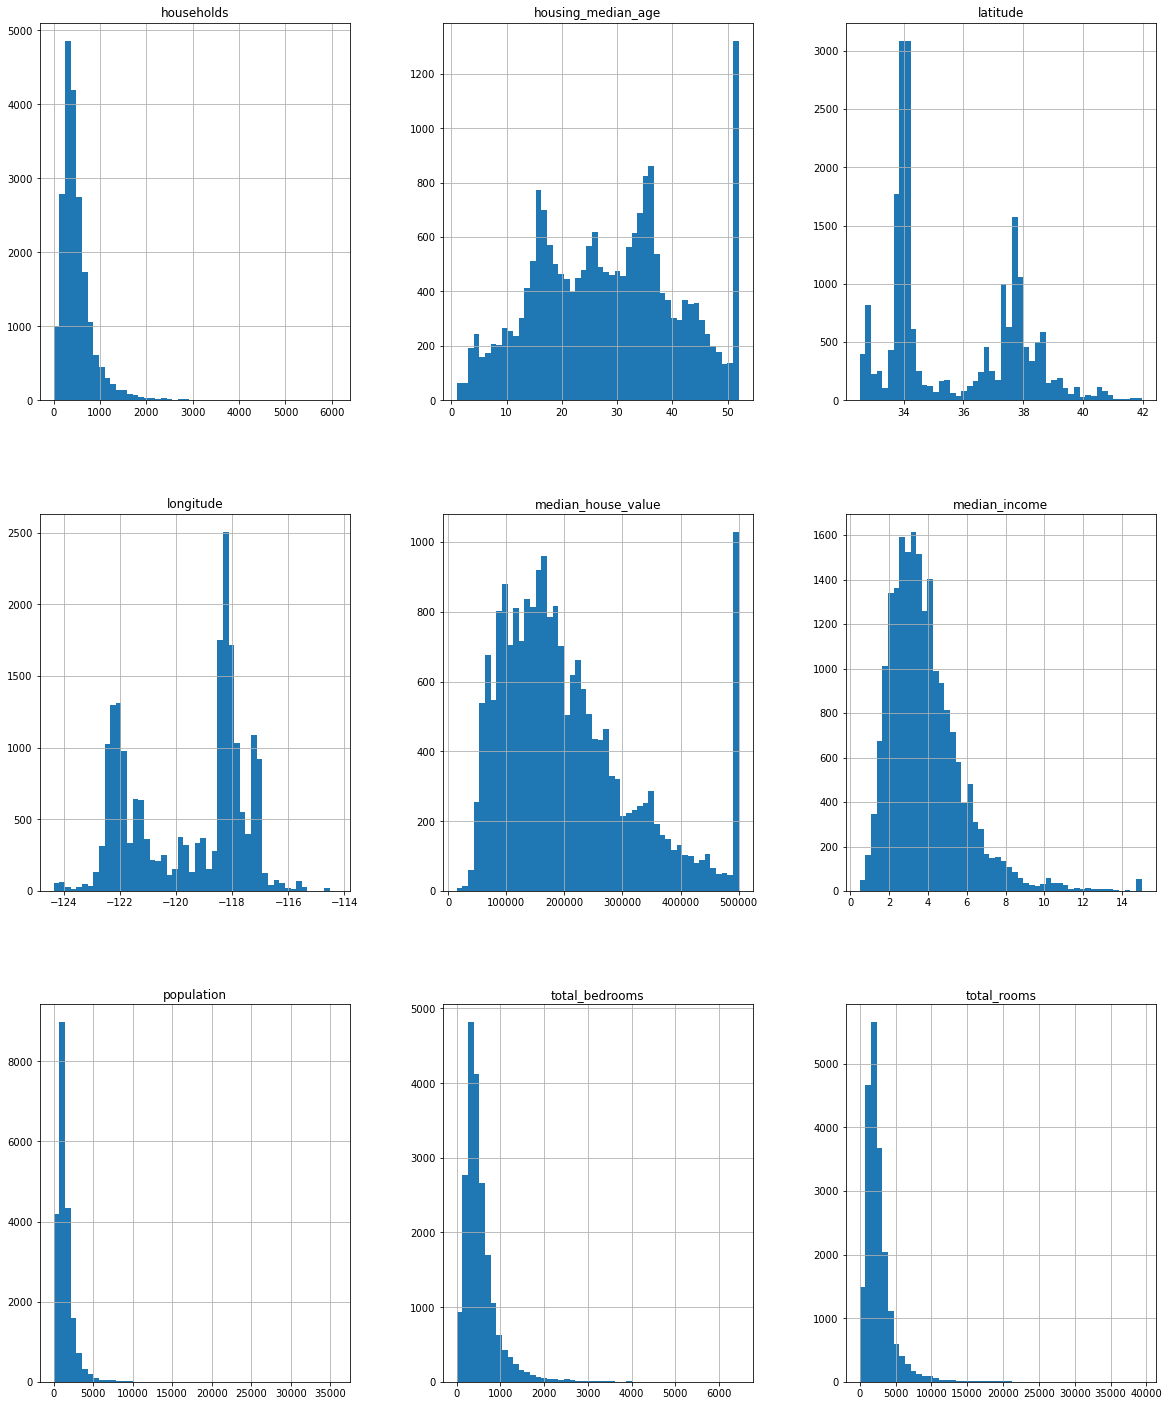

In [5]:
housing_df.hist(bins=50, figsize=(20,25))
plt.show()

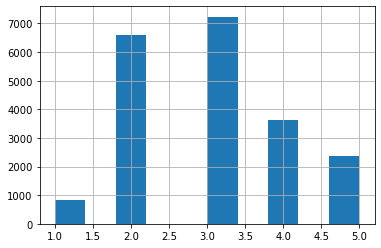

In [6]:
# introduce a category col to avoid skewed sets after splitting train and test
housing_df['income_cat'] = pd.cut(housing_df.median_income, bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing_df.income_cat.hist()  

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_df, housing_df.income_cat):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

In [8]:
strat_test_set.income_cat.value_counts()

3    1447
2    1316
4     728
5     473
1     164
Name: income_cat, dtype: int64

In [9]:
# after splitting train and test sets properly and the test set is not skewed, drop the category col
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True) # inplace: perform operations directly on the original DataFrame

In [10]:
# create a copy to avoid making changes on the original set
housing = strat_train_set.copy()
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,240200.0,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,113000.0,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,97800.0,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,225900.0,<1H OCEAN


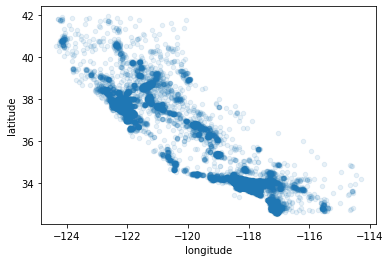

In [11]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

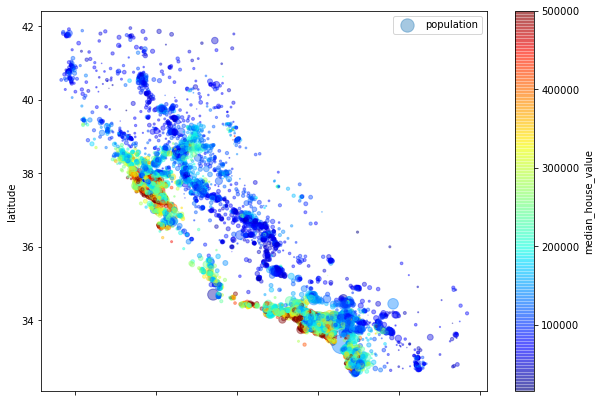

In [12]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing.population/100, label='population', figsize=(10, 7), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)

In [13]:
corr_matrix = housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

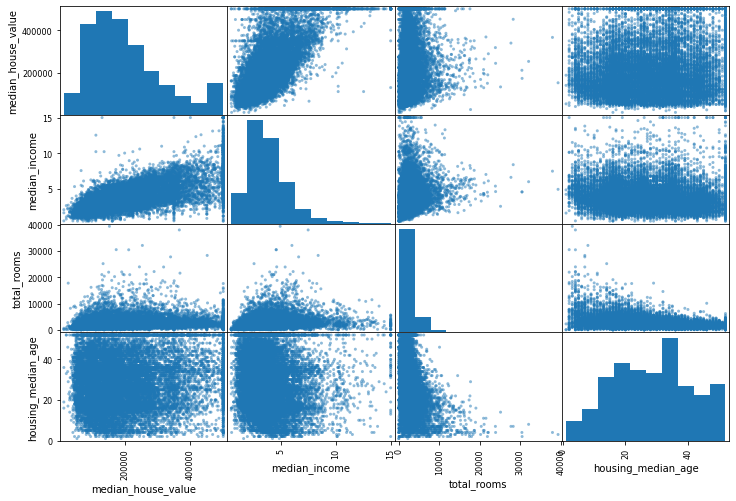

In [14]:
attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8));

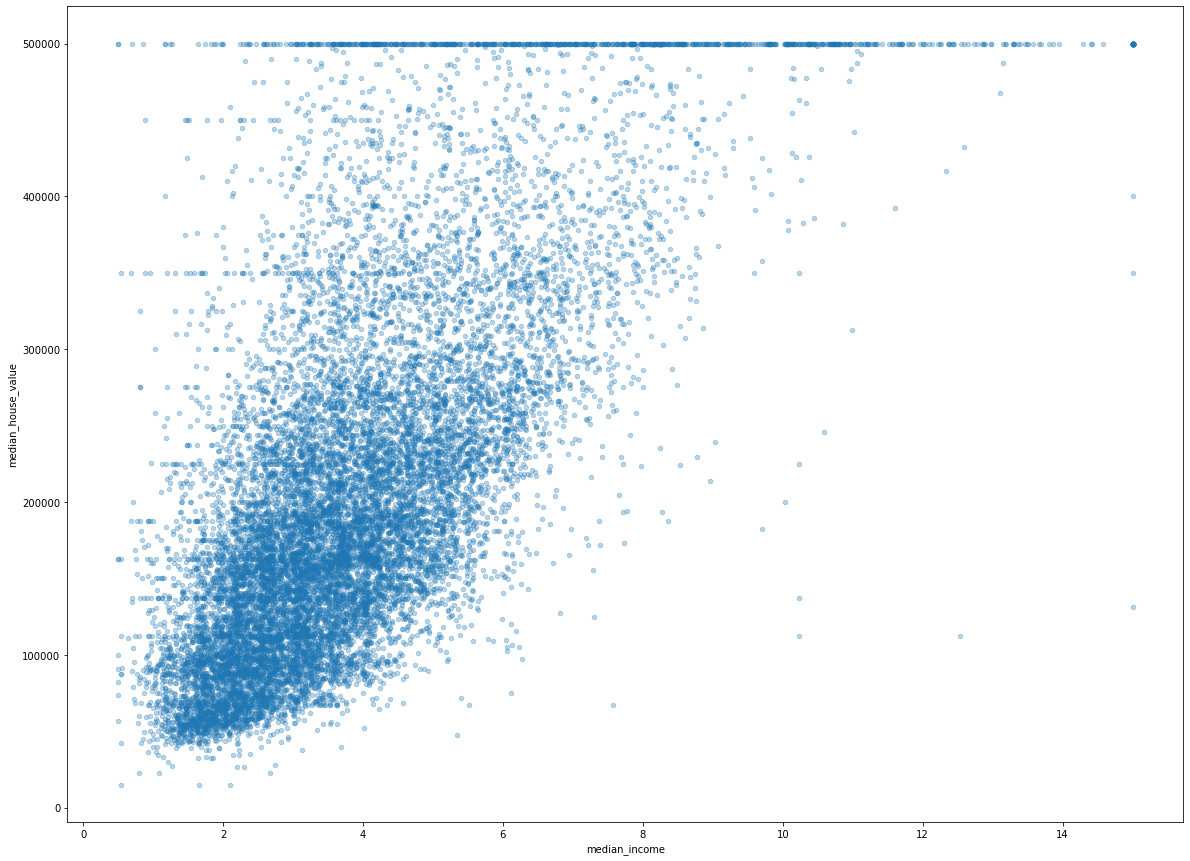

In [15]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.3, figsize=(20,15))

In [16]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,4.505810,0.231341,3.047847
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,240200.0,INLAND,6.052381,0.185681,2.728571
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,113000.0,INLAND,4.635659,0.245819,4.077519
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,97800.0,INLAND,6.346405,0.179609,2.742484
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,225900.0,<1H OCEAN,5.505618,0.193878,3.808989


In [17]:
corr_matrix = housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [18]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set.median_house_value.copy()
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN


In [19]:
imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [20]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


In [21]:
housing_cat = housing[['ocean_proximity']]
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [22]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [23]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

# Create an automated Pipeline

In [24]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6 # indexes of columns in a 2D array

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): 
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:,rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [25]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [26]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

# Select and train models

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
# evaluate metrics here



In [28]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels);

In [29]:
housing_pred = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [30]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([68641.9574499 , 67451.65812957, 69686.13870139, 69728.83088688,
       70643.0458648 , 74548.27953093, 72620.6291982 , 71314.23916624,
       76921.64575717, 69692.58329786])

In [31]:
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Std deviation: ', scores.std())

In [32]:
display_scores(tree_rmse_scores)

Scores:  [68641.9574499  67451.65812957 69686.13870139 69728.83088688
 70643.0458648  74548.27953093 72620.6291982  71314.23916624
 76921.64575717 69692.58329786]
Mean:  71124.9007982942
Std deviation:  2712.108240315591


In [33]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Std deviation:  2731.6740017983425


In [34]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels);

In [35]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rsme_scores = np.sqrt(-forest_scores)
display_scores(forest_rsme_scores)

Scores:  [49429.74276293 47501.75808868 49949.52289189 52133.53708331
 49677.51699756 53723.83901516 48872.14141847 48012.02010254
 52662.26452302 50398.40830713]
Mean:  50236.07511906955
Std deviation:  1923.6710396995572


In [36]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},    
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},  
]
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                            scoring='neg_mean_squared_error',
                            return_train_score=True)
grid_search.fit(housing_prepared, housing_labels);

In [37]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [38]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [39]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.93325077e-02, 7.17866715e-02, 4.40214273e-02, 1.65909244e-02,
       1.66985530e-02, 1.72803424e-02, 1.65924979e-02, 2.84989105e-01,
       7.13467794e-02, 1.11449749e-01, 1.05988768e-01, 1.35727553e-02,
       1.42740027e-01, 7.89698968e-05, 3.23206879e-03, 4.29885328e-03])

In [40]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.2849891046787567, 'median_income'),
 (0.14274002745365819, 'INLAND'),
 (0.11144974896811671, 'pop_per_hhold'),
 (0.10598876797335068, 'bedrooms_per_room'),
 (0.07933250769119396, 'longitude'),
 (0.07178667151638934, 'latitude'),
 (0.07134677938250865, 'rooms_per_hhold'),
 (0.04402142731578636, 'housing_median_age'),
 (0.01728034243474399, 'population'),
 (0.016698553033204874, 'total_bedrooms'),
 (0.016592497890254503, 'households'),
 (0.016590924413463104, 'total_rooms'),
 (0.013572755285482359, '<1H OCEAN'),
 (0.0042988532771069616, 'NEAR OCEAN'),
 (0.0032320687892173263, 'NEAR BAY'),
 (7.896989676633954e-05, 'ISLAND')]

In [41]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_pred = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(final_mse)

In [42]:
final_rmse

48098.77789284045

In [43]:
from scipy import stats

confidence = 0.95
squared_errors = (final_pred - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                            loc=squared_errors.mean(),
                            scale=stats.sem(squared_errors)))

array([46094.31492241, 50022.98473105])

# Exercises

## Exercise 1

In [44]:
svr_grid_params = [
    {'kernel': ['linear'], 'C': [1,10,100,1000,5000,1000]},
    {'kernel': ['rbf'], 'C': [1,10,100], 'gamma': [0.001,0.0001]}
]

svr_reg = SVR()
svr_grid_search = GridSearchCV( svr_reg, svr_grid_params, cv=5,
                                scoring='neg_mean_squared_error',
                                return_train_score=True)

svr_grid_search.fit(housing_prepared, housing_labels);

In [45]:
best_svr = svr_grid_search.best_estimator_

best_svr_pred = best_svr.predict(X_test_prepared)
best_svr_mse = mean_squared_error(y_test, best_svr_pred)
best_svr_rmse = np.sqrt(best_svr_mse)
best_svr_rmse

68264.35043779157

### Observation  
The best SVR seems to perform even worse, as the mean error was even around 70K dollars, far worse than the estimation of experts

## Exercise 2

Experiment with RandomizedSearchCV instead of GridSearchCV

In [46]:
random_search_params = [
    {'kernel': ['linear'], 'C': stats.expon(scale=10)}
]

r_search = RandomizedSearchCV(SVR(), random_search_params, n_iter=15,
                                scoring='neg_mean_squared_error', cv=5)
r_search.fit(housing_prepared, housing_labels);

In [47]:
best_svr = r_search.best_estimator_
best_svr_pred = best_svr.predict(X_test_prepared)
best_svr_mse = mean_squared_error(y_test, best_svr_pred)
best_svr_rmse = np.sqrt(best_svr_mse)
best_svr_rmse

74437.20216967982

## Exercise 3

Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [48]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('minmax_scaler', MinMaxScaler())
])
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])
feature_select_pipeline = Pipeline([
    ('preprocess', full_pipeline),
    ('selector', SelectKBest(chi2, k=8))
])
fs_housing_prepared = feature_select_pipeline.fit_transform(housing, housing_labels)
fs_housing_prepared

array([[0.50478215, 0.7254902 , 0.15201859, ..., 0.        , 0.        ,
        0.        ],
       [0.47927736, 0.25490196, 0.40837368, ..., 0.        , 0.        ,
        0.        ],
       [0.02444208, 0.58823529, 0.1629081 , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.16471838, 0.15686275, 0.19119736, ..., 0.        , 0.        ,
        0.        ],
       [0.1360255 , 0.58823529, 0.24569316, ..., 0.        , 0.        ,
        0.        ],
       [0.55579171, 1.        , 0.21207294, ..., 0.        , 1.        ,
        0.        ]])

## Exercise 4

I experimented with 2 different pipelines, the ordinary one which was mentioned in the book and the other one includes a feature selector.

In [49]:
full_pred_pipeline = Pipeline([
    ('prep_pipeline', full_pipeline),
    ('rfr', final_model)
])
full_pred_pipeline.fit(housing, housing_labels)
full_pred = full_pred_pipeline.predict(X_test)
full_pred

array([488307.53333333, 268463.36666667, 239383.33333333, ...,
       320190.06666667, 168050.        , 118540.        ])

In [50]:
full_pred_pipeline_rmse = np.sqrt(mean_squared_error(y_test, full_pred))
full_pred_pipeline_rmse

47560.99322084164

In [51]:
fs_full_pred_pipeline = Pipeline([
    ('preprocessing', feature_select_pipeline),
    ('rfr', final_model)
])
fs_full_pred_pipeline.fit(housing, housing_labels)
fs_full_pred = fs_full_pred_pipeline.predict(X_test)
fs_full_pred_pipeline_rmse = np.sqrt(mean_squared_error(y_test, fs_full_pred))
fs_full_pred_pipeline_rmse

61676.36721262627

## Exercise 5

In [52]:
selector_k_values = [i for i in range(1, len(attributes)-1)]
feature_select_grid_params = [
    {'preprocessing__selector__score_func': [f_classif, f_regression, mutual_info_regression], 'preprocessing__selector__k': selector_k_values}
]
feature_select_grid_search = GridSearchCV(fs_full_pred_pipeline, feature_select_grid_params,
                                            scoring='neg_mean_squared_error')
feature_select_grid_search.fit(housing, housing_labels)
fs_final_model = feature_select_grid_search.best_estimator_
fs_final_pred = fs_final_model.predict(X_test)
fs_final_model_rsme = np.sqrt(mean_squared_error(y_test, fs_final_pred))

In [53]:
fs_final_model_rsme

47079.721031445624

## Learning report  ##

The chapter is very informative and it took me quite some time to digest all the concepts and really dive in the code. It also took me some more time to skim through the documentation of Scikit-learn to have a better understanding of different estimators and transformers used in the book as well as the meaning of the parameters they require. In the end, I have learnt the following things from this chapter:  

- How to carry out a Data Science project in a methodological way, with a checklist of tasks which are supposed to be carried out in a certain order. This is not mandatory but the list was compiled as a reference for novice data scientists to optimize the process of data cleaning and analysis. 
- Some main challenges when it comes to building an automated pipeline for data processing to fit the model such as handling missing data and outliers and handling different data types. For handling missing data, the chapter mentioned 3 methods which are commonly used, and I think beside using statistical values such as mean or median, we can also use a Machine Learning model to predict those missing values. However, this escalates the complexity of the project so other factors should be considered if one wants to carry out this method.
- Scikit-learn provides different types of pipelines and composers for data transforming, which can make the learning curve a bit steep but when one is used to it, they turn out to be very useful.
- Splitting train and test datasets also requires some testing and observation so ensure that the statistics (for example, the distribution of labels/classes) of test set and train set are the same so the model performance can be assessed properly
- The process of data cleaning, feature selection, model selection and hyper-parameter fine-tuning can be automated using pre-built packages, which takes some time to learn and understand but once set up, the automation can save a considerable amount of human labor in tuning the parameters manually, especially when the scale of the project is extended and there are several models to take care of.
- Creating customized estimators or transformers is doable but not a trivial task as it involves reading multiple documentation articles and one's familiarity with OOP concepts.
